In [77]:
import polars as pl
import pandas as pd
import time
import numpy as np
import requests
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from tqdm import tqdm
pd.set_option('display.max_columns', None)  # Toutes les colonnes
pd.set_option('display.width', None)        # Pas de limite de largeur pour les lignes
pd.set_option('display.max_colwidth', None) # Pas de limite pour la largeur des cellules


In [2]:
df_test = pl.read_csv('data_pop_density/dataframe_densite_amenities.csv')
df_test.tail(5)

lat,lon,densite,amenities,transports,shops,schools,parks,restaurants,healthcare,entertainment,cultural_places
f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64
41.345417,9.244583,8.738704,0,0,0,0,0,0,0,0,0
41.345417,9.252917,16.828238,0,0,0,0,0,0,0,0,0
41.345417,9.26125,14.136576,0,0,0,0,0,0,0,0,0
41.337083,9.252917,13.983237,0,0,0,0,0,0,0,0,0
41.337083,9.26125,12.697619,0,0,0,0,0,0,0,0,0


# Récupérations des données

## Etape de scrapping (Facultative)

In [3]:
!python script_scrapping_dvf.py

/home/phdel/.pyenv/versions/3.10.6/lib/python3.10/pty.py:89: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

If you really know what your doing, you can silence this warning with the warning module
or by setting POLARS_ALLOW_FORKING_THREAD=1.

  pid, fd = os.forkpty()


Fetching data for year: 2019
File already exists: 01.csv.gz
File already exists: 02.csv.gz
File already exists: 03.csv.gz
File already exists: 04.csv.gz
File already exists: 05.csv.gz
File already exists: 06.csv.gz
File already exists: 07.csv.gz
File already exists: 08.csv.gz
File already exists: 09.csv.gz
File already exists: 10.csv.gz
File already exists: 11.csv.gz
File already exists: 12.csv.gz
File already exists: 13.csv.gz
File already exists: 14.csv.gz
File already exists: 15.csv.gz
File already exists: 16.csv.gz
File already exists: 17.csv.gz
File already exists: 18.csv.gz
File already exists: 19.csv.gz
File already exists: 21.csv.gz
File already exists: 22.csv.gz
File already exists: 23.csv.gz
File already exists: 24.csv.gz
File already exists: 25.csv.gz
File already exists: 26.csv.gz
File already exists: 27.csv.gz
File already exists: 28.csv.gz
File already exists: 29.csv.gz
File already exists: 2A.csv.gz
File already exists: 2B.csv.gz
File already exists: 30.csv.gz
File alrea

## Chargement dans un DataFrame

### Fonctions

In [4]:
def change_column_types(df):
    """
    Change les types de plusieurs colonnes dans un DataFrame Polars.

    Parameters:
        df (pl.DataFrame): Le DataFrame Polars.
        columns_dtypes (dict): Un dictionnaire où les clés sont les noms de colonnes
                               et les valeurs sont les nouveaux types (ex: pl.Int64, pl.Float64).

    Returns:
        pl.DataFrame: Un nouveau DataFrame avec les colonnes modifiées.
    """
    dict_type ={'id_mutation': pl.Utf8, 'date_mutation': pl.Date, 'numero_disposition': pl.Utf8, 'nature_mutation': pl.Utf8, 'valeur_fonciere': pl.Float64, 'adresse_numero' : pl.Utf8, 'adresse_suffixe': pl.Utf8, 'adresse_nom_voie': pl.Utf8, 'adresse_code_voie' : pl.Utf8, 'code_postal':pl.Utf8, 'code_commune':pl.Utf8, 'nom_commune':pl.Utf8, 'code_departement':pl.Utf8, 'ancien_code_commune':pl.Utf8, 'ancien_nom_commune':pl.Utf8, 'id_parcelle':pl.Utf8, 'ancien_id_parcelle':pl.Utf8, 'numero_volume':pl.Utf8, 'lot1_numero':pl.Utf8, 'lot1_surface_carrez':pl.Float64, 'lot2_numero':pl.Utf8, 'lot2_surface_carrez':pl.Float64, 'lot3_numero':pl.Utf8, 'lot3_surface_carrez':pl.Float64, 'lot4_numero':pl.Utf8, 'lot4_surface_carrez':pl.Float64, 'lot5_numero':pl.Utf8, 'lot5_surface_carrez':pl.Float64, 'nombre_lots':pl.Float64, 'code_type_local': pl.Utf8, 'type_local': pl.Utf8, 'surface_reelle_bati': pl.Float64, 'nombre_pieces_principales': pl.Float64, 'code_nature_culture':pl.Utf8, 'nature_culture':pl.Utf8, 'code_nature_culture_speciale':pl.Utf8, 'nature_culture_speciale':pl.Utf8, 'surface_terrain':pl.Float64, 'longitude':pl.Float64, 'latitude':pl.Float64}
    for column_name, column_type in dict_type.items():
        df = df.with_columns(pl.col(column_name).cast(column_type))
    return df

def data_loader(path, departements = [], annees = []):

    df = pl.DataFrame()
    if not annees:
        annees_list = os.listdir(path)
    else:
        annees_list =[str(annee) for annee in annees]
    for annee in annees_list:
        cur_year = os.path.join(path,annee)
        if not departements:
            departements_list = os.listdir(cur_year)
        else:
            departements_list = [f"{departement}.csv.gz" if departement>9 else f"0{departement}.csv.gz" for departement in departements]
        for departement in departements_list:
            file = os.path.join(cur_year,departement)
            temp_df = pl.read_csv(file,ignore_errors=True)
            temp_df = change_column_types(temp_df)
            df = pl.concat([df, temp_df])

    return df


## Chargement des données:

In [5]:
path = 'data_dvf'
df = data_loader(path,departements=[75,92,93,94])

In [6]:
df = df.filter(
    pl.col("valeur_fonciere").is_not_null() &
    pl.col("longitude").is_not_null() &
    pl.col("latitude").is_not_null() &
    (pl.col("surface_reelle_bati").is_not_nan() | pl.col("surface_terrain").is_not_nan())
)
df.head()

id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
str,date,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,f64,str,f64,str,f64,str,f64,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64
"""2023-1317095""",2023-01-03,"""1""","""Vente""",1.825e6,"""89""",null,"""RUE SAINT-DENIS""","""8525""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AP0050""",null,null,"""1""",95.21,"""26""",null,"""27""",null,"""28""",null,"""29""",null,7.0,"""4""","""Local industriel. commercial o…",165.0,0.0,null,null,null,null,null,2.349112,48.862083
"""2023-1317096""",2023-01-05,"""1""","""Vente""",567000.0,"""51""",null,"""RUE DE L ECHIQUIER""","""3084""","""75010""","""75110""","""Paris 10e Arrondissement""","""75""",null,null,"""75110000AV0075""",null,null,"""7""",null,"""8""",null,null,null,null,null,null,null,2.0,"""4""","""Local industriel. commercial o…",52.0,0.0,null,null,null,null,null,2.348283,48.871818
"""2023-1317097""",2023-01-04,"""1""","""Vente""",140000.0,"""178""",null,"""RUE DE COURCELLES""","""2387""","""75017""","""75117""","""Paris 17e Arrondissement""","""75""",null,null,"""75117000BG0053""",null,null,"""57""",18.75,"""58""",null,null,null,null,null,null,null,2.0,"""2""","""Appartement""",18.0,1.0,null,null,null,null,null,2.298612,48.884255
"""2023-1317098""",2023-01-05,"""1""","""Vente""",400000.0,"""12""",null,"""RUE TURGOT""","""9508""","""75009""","""75109""","""Paris 9e Arrondissement""","""75""",null,null,"""75109000BD0036""",null,null,"""831""",43.8,null,null,null,null,null,null,null,null,1.0,"""2""","""Appartement""",43.0,1.0,null,null,null,null,null,2.345859,48.880564
"""2023-1317100""",2023-01-03,"""1""","""Vente""",295000.0,"""18""",null,"""RUE EMILE LEVEL""","""3246""","""75017""","""75117""","""Paris 17e Arrondissement""","""75""",null,null,"""75117000DG0040""",null,null,"""14""",null,"""15""",null,null,null,null,null,null,null,2.0,"""2""","""Appartement""",28.0,2.0,null,null,null,null,null,2.318419,48.893075


## BASELINE : Prétraitement des données et premier modèle

In [7]:
data = df[['date_mutation','type_local','surface_reelle_bati','nombre_pieces_principales','nature_culture','surface_terrain','longitude','latitude','valeur_fonciere']]

# # Calculer la composante saisonnière
data = data.with_columns([
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.sin(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("sin_month"),
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.cos(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("cos_month"),
    pl.col("date_mutation").dt.year().alias('year')
])

In [8]:
data.head(2)

date_mutation,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
date,str,f64,f64,str,f64,f64,f64,f64,f64,f64,i32
2023-01-03,"""Local industriel. commercial o…",165.0,0.0,null,null,2.349112,48.862083,1.825e6,0.5,0.866025,2023
2023-01-05,"""Local industriel. commercial o…",52.0,0.0,null,null,2.348283,48.871818,567000.0,0.5,0.866025,2023


In [9]:
data.describe()

statistic,date_mutation,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year
str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""679736""","""657978""",598981.0,657761.0,"""207666""",207636.0,679736.0,679736.0,679736.0,679736.0,679736.0,679736.0
"""null_count""","""0""","""21758""",80755.0,21975.0,"""472070""",472100.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2021-11-25 20:33:41.952000""",null,78.273014,2.235479,null,1979.515527,2.36585,48.858045,4.0494e6,-0.037315,0.020649,2021.370317
"""std""",null,null,404.850517,1.6325,null,5761.434546,0.094229,0.048895,1.9282e7,0.68347,0.728733,1.484293
"""min""","""2019-07-01""","""Appartement""",1.0,0.0,"""bois""",1.0,2.146007,48.688515,0.15,-1.0,-1.0,2019.0
"""25%""","""2020-09-28""",null,33.0,1.0,null,228.0,2.295287,48.827881,243900.0,-0.5,-0.866025,2020.0
"""50%""","""2021-11-25""",null,53.0,2.0,null,407.0,2.352636,48.86269,426000.0,-2.4493e-16,6.1232e-17,2021.0
"""75%""","""2023-01-16""",null,76.0,3.0,null,1009.0,2.427576,48.89092,1e6,0.5,0.866025,2023.0
"""max""","""2024-06-29""","""Maison""",100000.0,78.0,"""vergers""",165228.0,2.602809,49.00501,7.62e8,1.0,1.0,2024.0


In [10]:
from sklearn.model_selection import train_test_split
data_test = data.filter(pl.col('valeur_fonciere')<3e6)
y = data_test['valeur_fonciere']
X = data_test.drop(['valeur_fonciere'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
categorical_columns_onehot = ['nature_culture','type_local'] # Columns that need OneHotEncoding
numerical_columns = X.select(pl.col(pl.Float64)).columns # Numerical columns
# Encoding and imputer Pipeline

def replace_none_with_nan(X):
    numerical_columns = X.select(pl.col(pl.Float64)).columns
    for col in numerical_columns:
        X = X.with_columns(
            pl.col(col).cast(pl.Float64).fill_null(np.nan).alias(col)
            )
    return X

onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute les valeurs manquantes
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot Encoding
])

numeric_pipeline = Pipeline(steps=[
    ('replace_null_to_nan', FunctionTransformer(replace_none_with_nan)),
    ('imputer', SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)),  # Remplit les NaN avec 0
    ('scaler', StandardScaler())                 # Standardisation
])

# Encoding pipeline

column_transformer =  ColumnTransformer(
    transformers=[
        ('onehot', onehot_pipeline, categorical_columns_onehot),
        ('numeric', numeric_pipeline, numerical_columns)
    ]
)

In [12]:
from sklearn import set_config

# Configuration pour afficher graphiquement
set_config(display="diagram")

# Afficher la pipeline dans un notebook
display(column_transformer)


ColumnTransformer(transformers=[('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['nature_culture', 'type_local']),
                                ('numeric',
                                 Pipeline(steps=[('replace_null_to_nan',
                                                  FunctionTransformer(func=<function replace_none_with_nan at 0x7f57d3749090>)),
                                                 ('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['surface_reelle_bati',
                                  'nombre_pieces_principales',
                                  'surface_terrain', 'longitude', 'latitude',
                                  'sin_month', 'cos_month'])])

In [13]:
model = LinearRegression()

LR_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('linear_model',model)
])
display(LR_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('replace_null_to_nan',
                                                                   FunctionTransformer(func=<function replace_none_with_nan at 0x7f57d3749090>)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('linear_model', LinearRegression())])

In [14]:
LR_pipeline.fit(X_train,y_train)
y_pred = LR_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')

 R² = 0.2160486656391164


In [15]:
model = lgb.LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

lgb_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('linear_model',model)
])
display(lgb_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['nature_culture',
                                                   'type_local']),
                                                 ('numeric',
                                                  Pipeline(steps=[('replace_null_to_nan',
                                                                   FunctionTransformer(func=<function replace_none_with_nan at 0x7f57d3749090>)),
                                                                  ('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['surface_reelle_bati',
                                                   'nombre_pieces_principales',
                                                   'surface_terrain',
                                                   'longitude', 'latitude',
                                                   'sin_month',
                                                   'cos_month'])])),
                ('linear_model', LGBMRegressor(random_state=42))])

In [16]:
lgb_pipeline.fit(X_train,y_train)
y_pred = lgb_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 464888, number of used features: 23
[LightGBM] [Info] Start training from score 523276.281605
 R² = 0.5532886603996963


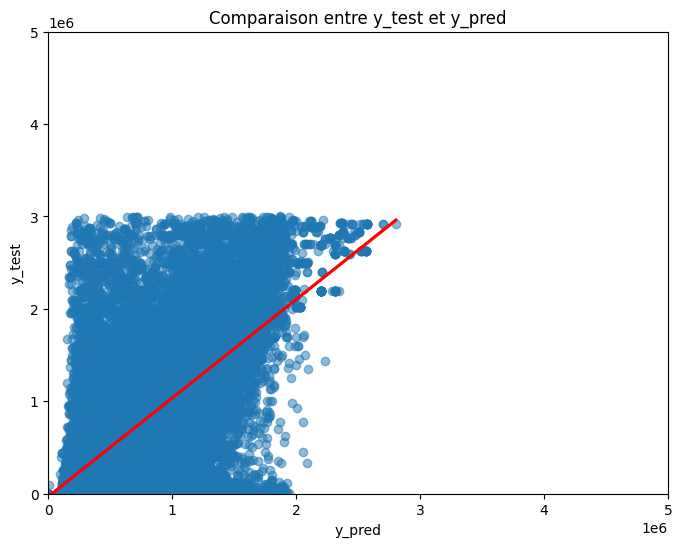

In [17]:
validation = pl.DataFrame()
validation = pl.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Tracer avec seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,5e6)
plt.ylim(0,5e6)
plt.title("Comparaison entre y_test et y_pred")
plt.show()


In [18]:
class YToNumpyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, y):
        if isinstance(y, (pl.DataFrame, pl.Series)):
            y = y.to_numpy()
        return np.log(y)
    def inverse_transform(self, y):
        # Si aucune transformation inverse n'est nécessaire, renvoyez simplement y
        return np.exp(y)

class ToNumpyTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Si X est un DataFrame ou une série Polars, le convertir en NumPy array
        if isinstance(X, pl.DataFrame):
            return X.to_numpy()
        elif isinstance(X, pl.Series):
            return X.to_numpy().reshape(-1, 1)
        return X

model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE')
catboost_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('to_numpy',ToNumpyTransformer()),
    ('catboost_model',model)
])



# Pipeline pour X
catboost_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('to_numpy', ToNumpyTransformer()),
    ('catboost_model', model)
])

# Pipeline pour y avec TransformedTargetRegressor
final_pipeline = TransformedTargetRegressor(
    regressor=catboost_pipeline,
    transformer=YToNumpyTransformer()
)
display(final_pipeline)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('onehot',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                                       ('onehot',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['nature_culture',
                                                                                        'type_local']),
                                                                                      ('numeric',
                                                                                       Pipeline(steps=[('replace_null_to_nan',
                                                                                                        FunctionTransformer(func=<function repl...
                                                                                                       ('imputer',
                                                                                                        SimpleImputer(fill_value=0,
                                                                                                                      strategy='constant')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['surface_reelle_bati',
                                                                                        'nombre_pieces_principales',
                                                                                        'surface_terrain',
                                                                                        'longitude',
                                                                                        'latitude',
                                                                                        'sin_month',
                                                                                        'cos_month'])])),
                                                     ('to_numpy',
                                                      ToNumpyTransformer()),
                                                     ('catboost_model',
                                                      <catboost.core.CatBoostRegressor object at 0x7f571605b880>)]),
                           transformer=YToNumpyTransformer())

0:	learn: 1.4768303	total: 93.2ms	remaining: 1m 33s
1:	learn: 1.4534496	total: 126ms	remaining: 1m 3s
2:	learn: 1.4341066	total: 160ms	remaining: 53.3s
3:	learn: 1.4163120	total: 191ms	remaining: 47.6s
4:	learn: 1.4023973	total: 221ms	remaining: 44s
5:	learn: 1.3901607	total: 247ms	remaining: 41s
6:	learn: 1.3776885	total: 274ms	remaining: 38.8s
7:	learn: 1.3676843	total: 304ms	remaining: 37.7s
8:	learn: 1.3586621	total: 340ms	remaining: 37.4s
9:	learn: 1.3511609	total: 367ms	remaining: 36.3s
10:	learn: 1.3447618	total: 394ms	remaining: 35.4s
11:	learn: 1.3358439	total: 420ms	remaining: 34.6s
12:	learn: 1.3308104	total: 450ms	remaining: 34.2s
13:	learn: 1.3239986	total: 478ms	remaining: 33.6s
14:	learn: 1.3196571	total: 507ms	remaining: 33.3s
15:	learn: 1.3154419	total: 538ms	remaining: 33.1s
16:	learn: 1.3117310	total: 570ms	remaining: 33s
17:	learn: 1.3081206	total: 604ms	remaining: 32.9s
18:	learn: 1.3053903	total: 631ms	remaining: 32.6s
19:	learn: 1.3017783	total: 658ms	remaining: 

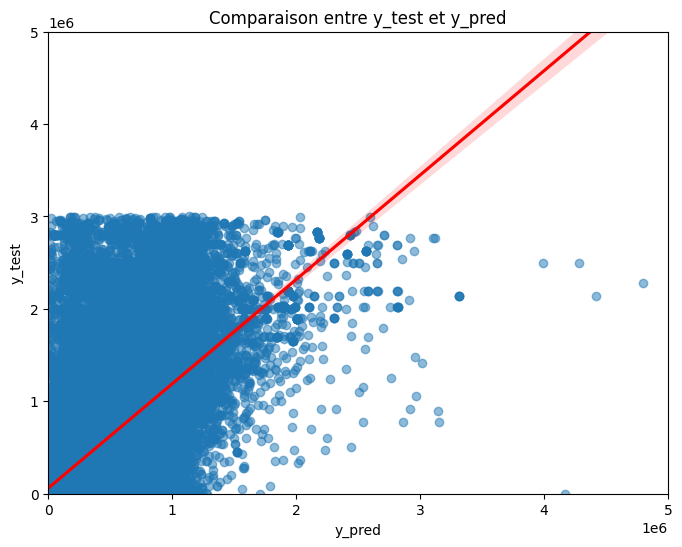

In [19]:
final_pipeline.fit(X_train,y_train)
y_pred = final_pipeline.predict(X_test)

r2 =  r2_score(y_test,y_pred)
print(f' R² = {r2}')
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'MAPE: {mape:.2f}%')
validation = pl.DataFrame()
validation = pl.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})

# Tracer avec seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("y_pred")
plt.ylabel("y_test")
plt.xlim(0,5e6)
plt.ylim(0,5e6)
plt.title("Comparaison entre y_test et y_pred")
plt.show()


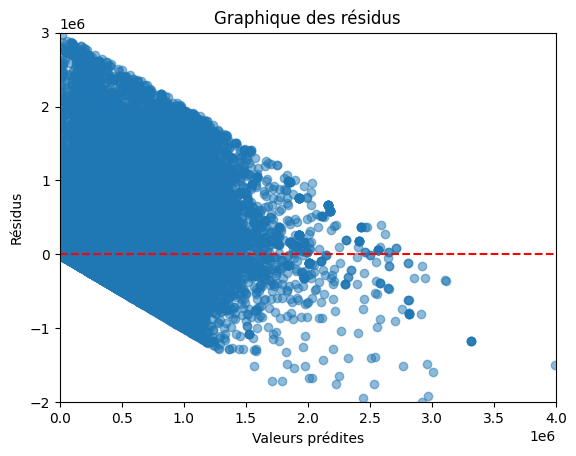

In [20]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlim(0,0.4e7)
plt.ylim(-0.2e7,0.3e7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Graphique des résidus')
plt.show()


Beaucoup d'hétéroscédasticité

## Modele plus puissant: Feature engineering

In [21]:
path = 'data_dvf'
df = data_loader(path,departements=[75,92,93,94])
df.head()

id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
str,date,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,f64,str,f64,str,f64,str,f64,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64
"""2023-1317095""",2023-01-03,"""1""","""Vente""",1.825e6,"""89""",null,"""RUE SAINT-DENIS""","""8525""","""75001""","""75101""","""Paris 1er Arrondissement""","""75""",null,null,"""75101000AP0050""",null,null,"""1""",95.21,"""26""",null,"""27""",null,"""28""",null,"""29""",null,7.0,"""4""","""Local industriel. commercial o…",165.0,0.0,null,null,null,null,null,2.349112,48.862083
"""2023-1317096""",2023-01-05,"""1""","""Vente""",567000.0,"""51""",null,"""RUE DE L ECHIQUIER""","""3084""","""75010""","""75110""","""Paris 10e Arrondissement""","""75""",null,null,"""75110000AV0075""",null,null,"""7""",null,"""8""",null,null,null,null,null,null,null,2.0,"""4""","""Local industriel. commercial o…",52.0,0.0,null,null,null,null,null,2.348283,48.871818
"""2023-1317097""",2023-01-04,"""1""","""Vente""",140000.0,"""178""",null,"""RUE DE COURCELLES""","""2387""","""75017""","""75117""","""Paris 17e Arrondissement""","""75""",null,null,"""75117000BG0053""",null,null,"""57""",18.75,"""58""",null,null,null,null,null,null,null,2.0,"""2""","""Appartement""",18.0,1.0,null,null,null,null,null,2.298612,48.884255
"""2023-1317098""",2023-01-05,"""1""","""Vente""",400000.0,"""12""",null,"""RUE TURGOT""","""9508""","""75009""","""75109""","""Paris 9e Arrondissement""","""75""",null,null,"""75109000BD0036""",null,null,"""831""",43.8,null,null,null,null,null,null,null,null,1.0,"""2""","""Appartement""",43.0,1.0,null,null,null,null,null,2.345859,48.880564
"""2023-1317099""",2023-01-04,"""1""","""Vente""",141343.12,"""63""","""B""","""RUE DAMREMONT""","""2534""","""75018""","""75118""","""Paris 18e Arrondissement""","""75""",null,null,"""75118000AK0014""",null,null,"""34""",11.4,null,null,null,null,null,null,null,null,1.0,"""3""","""Dépendance""",null,0.0,null,null,null,null,null,2.334615,48.891525


In [22]:
df = df.filter(
    pl.col("valeur_fonciere").is_not_null() &
    pl.col("longitude").is_not_null() &
    pl.col("latitude").is_not_null() &
    (pl.col("surface_reelle_bati").is_not_nan() | pl.col("surface_terrain").is_not_nan())
)

data = df[['date_mutation','type_local','surface_reelle_bati','nombre_lots','lot1_surface_carrez','lot2_surface_carrez','lot3_surface_carrez','lot4_surface_carrez','lot5_surface_carrez','nombre_pieces_principales','nature_culture','surface_terrain','longitude','latitude','valeur_fonciere']]


data = data.with_columns([
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.sin(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("sin_month"),
    pl.col("date_mutation").dt.month().map_batches(lambda x: np.cos(2 * np.pi * x / 12), return_dtype=pl.Float64).alias("cos_month"),
    pl.col("date_mutation").dt.year().alias('year'),
    pl.col('lot1_surface_carrez').fill_null(value=0),
    pl.col('lot2_surface_carrez').fill_null(value=0),
    pl.col('lot3_surface_carrez').fill_null(value=0),
    pl.col('lot4_surface_carrez').fill_null(value=0),
    pl.col('lot5_surface_carrez').fill_null(value=0),
    pl.col('surface_reelle_bati').fill_null(value=0),
    pl.col('surface_terrain').fill_null(value=0)
])


In [23]:
data = data.with_columns(
    (pl.col('lot1_surface_carrez')+pl.col('lot2_surface_carrez')+pl.col('lot3_surface_carrez')+pl.col('lot4_surface_carrez')+pl.col('lot5_surface_carrez')
).alias("total_surface_carrez"))

data = data.with_columns(
    pl.when(pl.col("total_surface_carrez") == 0)
            .then(pl.col("surface_reelle_bati"))
            .otherwise(pl.col("total_surface_carrez"))
            .alias("total_surface_carrez"),
    pl.when(pl.col("surface_reelle_bati") != 0)
            .then((pl.col("valeur_fonciere")/pl.col("surface_reelle_bati")).round(0))
            .otherwise((pl.col("valeur_fonciere")/pl.col("surface_terrain")).round(0))
            .alias("valeur_fonciere_m2")
)
data.head()

date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0


In [24]:
from scipy.spatial import cKDTree
def idw_predict_kdtree(data, lon_col="longitude", lat_col="latitude", value_col="valeur_fonciere_m2", power=2, k=10):
    """
    Prédit les valeurs d'un DataFrame en utilisant l'Interpolation Inverse Distance Weighting (IDW) optimisée avec un KD-Tree.

    Paramètres :
        data : pl.DataFrame, DataFrame contenant les colonnes latitude, longitude et valeur foncière.
        lat_col : str, nom de la colonne latitude.
        lon_col : str, nom de la colonne longitude.
        value_col : str, nom de la colonne des valeurs à prédire.
        power : float, puissance de pondération (typiquement 2).
        k : int, nombre de voisins à considérer pour chaque point.

    Retourne :
        pl.Series, colonne des valeurs prédites pour chaque point.
    """
    # Extraire les coordonnées et les valeurs
    coordinates = data.select([lat_col, lon_col]).to_numpy()
    values = data[value_col].to_numpy()

    # Construire le KD-Tree
    tree = cKDTree(coordinates)

    predicted_values = []
    for i, point in enumerate(coordinates):
        # Trouver les k voisins les plus proches
        distances, indices = tree.query(point, k=k + 1)  # k+1 car le point lui-même est inclus

        # Exclure le point lui-même (distance 0)
        mask = distances > 0
        distances = distances[mask]
        indices = indices[mask]

        # Si aucun voisin valide n'est trouvé
        if len(distances) == 0:
            predicted_values.append(values[i])  # Retourner la valeur du point lui-même
            continue

        # Calculer les poids en fonction des distances
        weights = 1 / (distances ** power)

        # Calculer la valeur interpolée
        interpolated_value = np.round(np.sum(weights * values[indices]) / np.sum(weights),-1)
        predicted_values.append(interpolated_value)

    return pl.Series(predicted_values).alias(f"{value_col}_predite_par_le_quartier")


In [25]:
data = data.with_columns(
    idw_predict_kdtree(data, lon_col="longitude",lat_col="latitude", value_col="valeur_fonciere_m2", k=100),
)
data.head()

date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_predite_par_le_quartier
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0,37650.0
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0,16140.0
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,12830.0
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0,15710.0
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0,9240.0


In [26]:
df_popd = pd.read_csv('data_pop_density/dataframe_densite&amenities_radius=500.csv')
df_popd.drop(columns='Unnamed: 0',inplace=True)
df_popd

,lat,lon,densite,transport_pois,education_pois,health_pois,food_pois,shopping_pois,park_pois,entertainment_pois,cultural_pois
0,41.337082,9.252916,13.983237,0,0,0,0,0,0,0,0
1,41.337082,9.261250,12.697619,0,0,0,0,0,0,0,0
2,41.345417,9.244583,8.738704,0,0,0,0,0,0,0,0
3,41.345417,9.252916,16.828238,0,0,0,0,0,0,0,0
4,41.345417,9.261250,14.136576,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
932759,51.078750,2.544583,237.373210,0,0,0,0,0,0,0,0
932760,51.078750,2.552917,435.237270,0,0,0,2,0,0,0,0
932761,51.087082,2.527917,236.395450,0,0,0,0,0,0,0,0
932762,51.087082,2.536250,191.215910,0,0,0,0,0,0,0,0


In [27]:
import numpy as np
import polars as pl
from scipy.spatial import cKDTree  # Importer cKDTree pour une recherche efficace des plus proches voisins

# Fonction pour trouver la densité la plus proche en utilisant cKDTree
def find_nearest_square_data(data, df_popd):
    """
    Trouve la densité de population du point le plus proche pour chaque point dans un DataFrame de données
    géographiques en utilisant un arbre k-d (cKDTree).

    Cette fonction cherche, pour chaque point dans `data`, le point le plus proche dans `df_popd`
    (en fonction de la distance géographique) et retourne la densité associée à ce point.

    Parameters:
    - data (polars.DataFrame): Le DataFrame contenant les coordonnées géographiques des points
      pour lesquels la densité doit être calculée. Il doit contenir les colonnes 'latitude' et 'longitude'.
    - df_popd (polars.DataFrame): Le DataFrame contenant les coordonnées géographiques des points
      de population et la densité associée. Il doit contenir les colonnes 'lat', 'lon' et 'densite'.

    Returns:
    - numpy.ndarray: Un tableau contenant les densités associées aux plus proches voisins pour
      chaque point de `data`.
    """
    latitudes_data = data['latitude'].to_numpy()
    longitudes_data = data['longitude'].to_numpy()

    latitudes_popd = df_popd['lat'].to_numpy()
    longitudes_popd = df_popd['lon'].to_numpy()
    densities_popd = df_popd['densite'].to_numpy()

    # Créer un cKDTree pour une recherche rapide des plus proches voisins
    tree = cKDTree(np.vstack((longitudes_popd, latitudes_popd)).T)

    # Chercher les voisins les plus proches pour chaque point de `data`
    distances, indices = tree.query(np.vstack((longitudes_data, latitudes_data)).T, k=4)

    # Récupérer les densités associées aux plus proches voisins
    nearest_densities = np.mean(densities_popd[indices], axis=1)

    return nearest_densities

# Appliquer la fonction pour ajouter la colonne 'nearest_density' au DataFrame
nearest_densities = find_nearest_square_data(data, df_popd)

# Ajouter la colonne 'nearest_density' à ton DataFrame Polars
data = data.with_columns(
    pl.Series('nearest_density', nearest_densities)
)

# Afficher le DataFrame résultant
data.head()


date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_predite_par_le_quartier,nearest_density
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0,37650.0,23625.48275
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0,16140.0,31969.799
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,12830.0,28359.6325
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0,15710.0,35389.7945
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0,9240.0,31816.34825


In [28]:
from scipy.spatial import cKDTree
import numpy as np
import polars as pl

def find_weighted_poi_counts(data, df_grid, poi_columns):
    """
    Calcule une moyenne pondérée des colonnes POIs des quatre voisins les plus proches
    pour chaque point du DataFrame `data` en utilisant un arbre k-d (cKDTree).

    Parameters:
    - data (polars.DataFrame): DataFrame contenant les coordonnées des points pour lesquels
      les POIs pondérés doivent être calculés. Il doit contenir les colonnes 'latitude' et 'longitude'.
    - df_grid (polars.DataFrame): DataFrame contenant le quadrillage avec coordonnées et colonnes POIs.
      Il doit contenir les colonnes 'lat', 'lon' et les colonnes spécifiées dans `poi_columns`.
    - poi_columns (list): Liste des noms des colonnes POIs dans `df_grid` à inclure dans les calculs.

    Returns:
    - polars.DataFrame: DataFrame enrichi avec les colonnes pondérées des POIs.
    """
    # Extraire les coordonnées des deux ensembles
    latitudes_data = data['latitude'].to_numpy()
    longitudes_data = data['longitude'].to_numpy()

    latitudes_grid = df_grid['lat'].to_numpy()
    longitudes_grid = df_grid['lon'].to_numpy()

    # Créer un cKDTree pour une recherche rapide
    tree = cKDTree(np.vstack((longitudes_grid, latitudes_grid)).T)

    # Chercher les 4 voisins les plus proches pour chaque point
    distances, indices = tree.query(np.vstack((longitudes_data, latitudes_data)).T, k=4)

    # Calculer les poids en fonction de l'inverse des distances
    weights = 1 / np.where(distances == 0, 1e-10, distances)  # Évite la division par zéro
    normalized_weights = weights / weights.sum(axis=1, keepdims=True)

    # Calculer les moyennes pondérées pour chaque colonne POI
    weighted_poi_data = {}
    for col in poi_columns:
        poi_values = df_grid[col].to_numpy()
        # Récupérer les valeurs des voisins pour cette colonne
        neighbors_poi = poi_values[indices]
        # Calculer la moyenne pondérée
        weighted_poi_data[f"{col}_weighted"] = np.floor((neighbors_poi * normalized_weights).sum(axis=1))

    # Ajouter les colonnes pondérées au DataFrame d'entrée
    return data.with_columns([
        pl.Series(name, values) for name, values in weighted_poi_data.items()
    ])


In [29]:
# Colonnes POIs à inclure dans les calculs
poi_columns = ['transport_pois', 'education_pois','health_pois', 'food_pois', 'shopping_pois', 'park_pois',	'entertainment_pois', 'cultural_pois']

# Calculer les moyennes pondérées
data_expanded = find_weighted_poi_counts(data,df_popd, poi_columns)

data_expanded


date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_predite_par_le_quartier,nearest_density,transport_pois_weighted,education_pois_weighted,health_pois_weighted,food_pois_weighted,shopping_pois_weighted,park_pois_weighted,entertainment_pois_weighted,cultural_pois_weighted
date,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-01-03,"""Local industriel. commercial o…",165.0,7.0,95.21,0.0,0.0,0.0,0.0,0.0,null,0.0,2.349112,48.862083,1.825e6,0.5,0.866025,2023,95.21,11061.0,37650.0,23625.48275,15.0,3.0,11.0,248.0,368.0,0.0,4.0,3.0
2023-01-05,"""Local industriel. commercial o…",52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,2.348283,48.871818,567000.0,0.5,0.866025,2023,52.0,10904.0,16140.0,31969.799,17.0,5.0,9.0,218.0,213.0,0.0,8.0,1.0
2023-01-04,"""Appartement""",18.0,2.0,18.75,0.0,0.0,0.0,0.0,1.0,null,0.0,2.298612,48.884255,140000.0,0.5,0.866025,2023,18.75,7778.0,12830.0,28359.6325,18.0,6.0,9.0,48.0,93.0,0.0,1.0,0.0
2023-01-05,"""Appartement""",43.0,1.0,43.8,0.0,0.0,0.0,0.0,1.0,null,0.0,2.345859,48.880564,400000.0,0.5,0.866025,2023,43.8,9302.0,15710.0,35389.7945,15.0,3.0,7.0,121.0,169.0,0.0,0.0,1.0
2023-01-03,"""Appartement""",28.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,null,0.0,2.318419,48.893075,295000.0,0.5,0.866025,2023,28.0,10536.0,9240.0,31816.34825,10.0,4.0,4.0,46.0,110.0,0.0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-06-27,"""Appartement""",59.0,2.0,60.02,0.0,0.0,0.0,0.0,3.0,null,0.0,2.349619,48.812681,350000.0,1.2246e-16,-1.0,2024,60.02,5932.0,9400.0,20282.81825,10.0,0.0,1.0,6.0,14.0,0.0,0.0,0.0
2024-01-29,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,"""sols""",138.0,2.369728,48.783782,590000.0,0.5,0.866025,2024,0.0,4275.0,36940.0,9044.6905,9.0,0.0,1.0,3.0,7.0,0.0,0.0,0.0
2024-01-29,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,"""sols""",7.0,2.369648,48.783866,590000.0,0.5,0.866025,2024,0.0,84286.0,10020.0,9044.6905,9.0,0.0,1.0,4.0,7.0,0.0,0.0,0.0


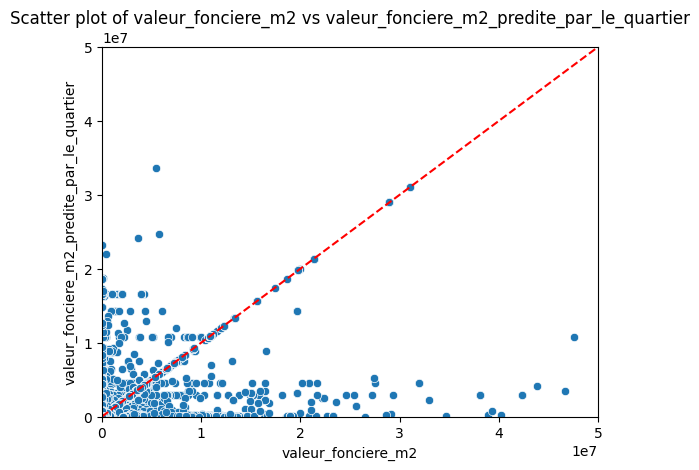

In [30]:
import seaborn as sns

# Conversion en pandas
df_pandas = data_expanded.to_pandas()

# Tracer avec Seaborn
sns.scatterplot(data=df_pandas, x="valeur_fonciere_m2", y="valeur_fonciere_m2_predite_par_le_quartier")
plt.plot([df_pandas["valeur_fonciere_m2"].min(), df_pandas["valeur_fonciere_m2"].max()],
         [df_pandas["valeur_fonciere_m2"].min(), df_pandas["valeur_fonciere_m2"].max()],
         color='red', linestyle='--', label="y=x Line")
plt.title("Scatter plot of valeur_fonciere_m2 vs valeur_fonciere_m2_predite_par_le_quartier")
plt.xlim((0,0.5e8))
plt.ylim((0,0.5e8))
plt.show()

/tmp/ipykernel_452134/2390057864.py:1: RuntimeWarning:

divide by zero encountered in log10



<Axes: xlabel='valeur_fonciere_m2_log', ylabel='Count'>

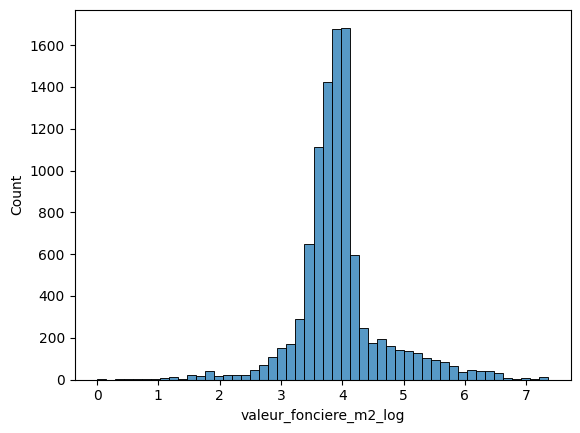

In [39]:
df_pandas['valeur_fonciere_m2_log']=df_pandas['valeur_fonciere_m2'].apply(lambda X: np.log10(X))


<Axes: xlabel='valeur_fonciere_m2_log', ylabel='Count'>

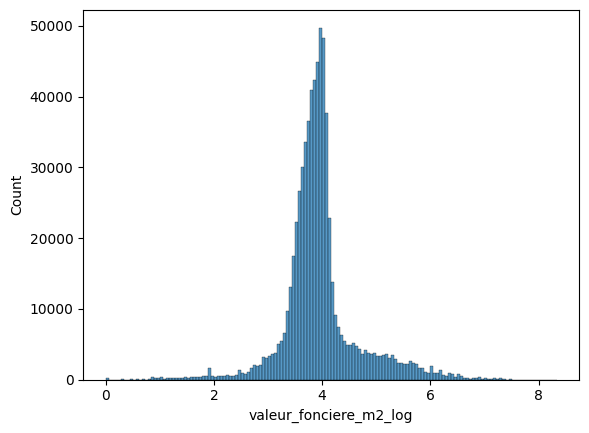

In [43]:
sns.histplot(data=df_pandas,x='valeur_fonciere_m2_log',bins=150)

In [49]:
df_pandas.columns

Index(['date_mutation', 'type_local', 'surface_reelle_bati', 'nombre_lots',
       'lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez',
       'lot4_surface_carrez', 'lot5_surface_carrez',
       'nombre_pieces_principales', 'nature_culture', 'surface_terrain',
       'longitude', 'latitude', 'valeur_fonciere', 'sin_month', 'cos_month',
       'year', 'total_surface_carrez', 'valeur_fonciere_m2',
       'valeur_fonciere_m2_predite_par_le_quartier', 'nearest_density',
       'transport_pois_weighted', 'education_pois_weighted',
       'health_pois_weighted', 'food_pois_weighted', 'shopping_pois_weighted',
       'park_pois_weighted', 'entertainment_pois_weighted',
       'cultural_pois_weighted', 'valeur_fonciere_m2_log'],
      dtype='object')

/tmp/ipykernel_452134/259394210.py:3: RuntimeWarning:

divide by zero encountered in log10

/tmp/ipykernel_452134/259394210.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='valeur_fonciere_m2_predite_par_le_quartier_log', ylabel='Count'>

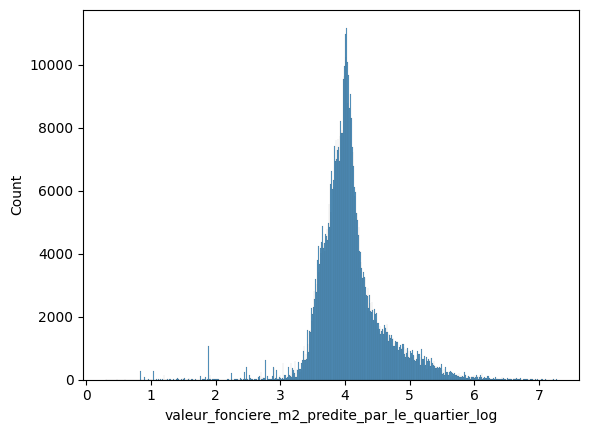

In [97]:
mask = (df_pandas['valeur_fonciere_m2_log']<5.5) & (df_pandas['total_surface_carrez']+df_pandas['surface_terrain']>1) & (df_pandas["nombre_pieces_principales"].notnull())
test_df =df_pandas[mask]
test_df['valeur_fonciere_m2_predite_par_le_quartier_log']=test_df['valeur_fonciere_m2_predite_par_le_quartier'].apply(lambda X: np.log10(X))
sns.histplot(data=test_df,x='valeur_fonciere_m2_predite_par_le_quartier_log')

In [ ]:
test_df.sort_values(by='surface_terrain')

,date_mutation,type_local,surface_reelle_bati,nombre_lots,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,valeur_fonciere,sin_month,cos_month,year,total_surface_carrez,valeur_fonciere_m2,valeur_fonciere_m2_predite_par_le_quartier,nearest_density,transport_pois_weighted,education_pois_weighted,health_pois_weighted,food_pois_weighted,shopping_pois_weighted,park_pois_weighted,entertainment_pois_weighted,cultural_pois_weighted,valeur_fonciere_m2_log,valeur_fonciere_m2_predite_par_le_quartier_log
0,2023-01-03,Local industriel. commercial ou assimilé,165.0,7.0,95.21,0.00,0.0,0.0,0.0,0.0,None,0.0,2.349112,48.862083,1825000.0,5.000000e-01,8.660254e-01,2023,95.21,11061.0,37650.0,23625.482750,15.0,3.0,11.0,248.0,368.0,0.0,4.0,3.0,4.043794,4.575765
412061,2020-05-19,Appartement,125.0,2.0,0.00,123.53,0.0,0.0,0.0,6.0,None,0.0,2.226287,48.821806,822200.0,5.000000e-01,-8.660254e-01,2020,123.53,6578.0,17180.0,7700.299400,9.0,2.0,3.0,4.0,12.0,0.0,0.0,0.0,3.818094,4.235023
412060,2020-05-13,Appartement,66.0,2.0,75.46,0.00,0.0,0.0,0.0,4.0,None,0.0,2.250559,48.833125,518200.0,5.000000e-01,-8.660254e-01,2020,75.46,7852.0,15590.0,25146.025500,9.0,2.0,4.0,22.0,70.0,0.0,0.0,0.0,3.894980,4.192846
412059,2020-05-13,Appartement,10.0,1.0,0.00,0.00,0.0,0.0,0.0,1.0,None,0.0,2.250559,48.833125,518200.0,5.000000e-01,-8.660254e-01,2020,10.00,51820.0,15590.0,25146.025500,9.0,2.0,4.0,22.0,70.0,0.0,0.0,0.0,4.714497,4.192846
412058,2020-06-02,Appartement,25.0,2.0,24.97,0.00,0.0,0.0,0.0,2.0,None,0.0,2.189046,48.811394,165000.0,1.224647e-16,-1.000000e+00,2020,24.97,6600.0,9500.0,7033.776250,9.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,3.819544,3.977724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527038,2021-02-09,Dépendance,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,sols,55830.0,2.157425,48.875644,3000000.0,8.660254e-01,5.000000e-01,2021,0.00,54.0,6400.0,2922.993375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.732394,3.806180
527044,2021-02-09,Local industriel. commercial ou assimilé,6244.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,sols,55830.0,2.157425,48.875644,3000000.0,8.660254e-01,5.000000e-01,2021,6244.00,480.0,6400.0,2922.993375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.681241,3.806180
230197,2022-09-29,Local industriel. commercial ou assimilé,440.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,sols,57854.0,2.448175,48.941985,39600000.0,-1.000000e+00,-1.836970e-16,2022,440.00,90000.0,20840.0,7546.229250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.954243,4.318898
247853,2022-05-10,Local industriel. commercial ou assimilé,5693.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,sols,116012.0,2.449448,48.758794,189324992.0,5.000000e-01,-8.660254e-01,2022,5693.00,33256.0,62300.0,5284.261300,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.521870,4.794488


: 

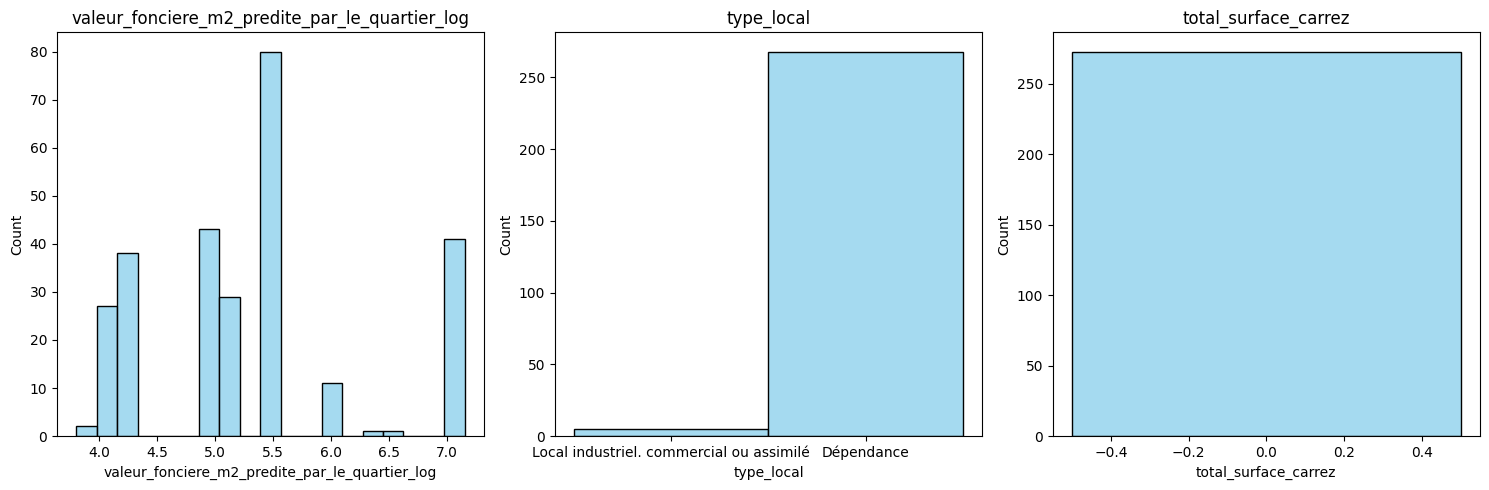

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste des colonnes à tracer
columns_to_plot = [
    'valeur_fonciere_m2_predite_par_le_quartier_log',
    'type_local',
    'total_surface_carrez'
]

# Nombre de colonnes pour l'affichage des subplots
n_cols = len(columns_to_plot)

# Configurer la figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5))

# Tracer chaque histogramme
for ax, column in zip(axes, columns_to_plot):
    sns.histplot(data=test_df, x=column, ax=ax, color='skyblue')
    ax.set_title(column)

# Ajuster les espacements
plt.tight_layout()
plt.show()


In [73]:
import plotly.express as px

# Exemple de DataFrame pandas
df_pandas_sampled = df_pandas.sample(10000)  # Prendre un échantillon de 10 000 points

# Création de la carte avec Plotly Express
fig = px.scatter_mapbox(
    df_pandas_sampled,
    lat="latitude",  # Colonne pour les latitudes
    lon="longitude",  # Colonne pour les longitudes
    size="valeur_fonciere_m2",  # Taille des cercles basée sur la valeur/m²
    color="valeur_fonciere_m2",  # Couleur des cercles basée sur la valeur/m²
    color_continuous_scale=px.colors.sequential.Blues,  # Palette de couleurs
    size_max=15,  # Taille maximale des cercles
    zoom=13,  # Niveau de zoom initial
    mapbox_style="carto-positron",  # Style de carte
    title="Carte des valeurs foncières au m²"
)

# Ajouter des popups avec les informations
fig.update_traces(
    hovertemplate="<b>Prix/m²</b>: %{marker.size} €<br><b>Latitude</b>: %{lat}<br><b>Longitude</b>: %{lon}"
)

# Afficher la carte
fig.show()
